# Exploring Score-based  Patient matching
This notebook introduces key concepts of patient matching while demonstrating those concepts using python

*********************

## About this notebook

This notebook follows  step by step the record linkage process , providing minimum exaplanation and assuming certain knowledge of the process. Our aim is to compare different score-based matching strategies using synthetic  data.
For more detailed information, please consult the reference section

In [37]:
import recordlinkage  as rl
import numpy as np
import pandas as pd
import warnings
from recordlinkage.index import Block
from recordlinkage.datasets import load_febrl4,load_febrl3,load_febrl2,load_febrl1
from recordlinkage.preprocessing import phonetic,clean

import matplotlib as mlp
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#### Get version information

In [38]:
# Get Version information
print("Pandas version: {0}".format(pd.__version__),'\n')
print("Python Record Linkage version: {0}".format(rl._version.get_versions()['version']),'\n')
print("Numpy version: {0}".format(np.__version__),'\n')

Pandas version: 1.5.3 

Python Record Linkage version: 0.15 

Numpy version: 1.20.3 



## Importing dataset to deduplicate

In [24]:
# file to deduplicate
IMPORT_FILE_TO_DEDUPLICATE = './data/dataset_febrl3.csv'
#df_a = pd.read_csv(IMPORT_FILE_TO_DEDUPLICATE)
df_a = pd.read_csv(IMPORT_FILE_TO_DEDUPLICATE,
                    index_col="rec_id",
                    sep=",",
                    engine='c',
                    skipinitialspace=True,
                    encoding='utf-8',
                    parse_dates=["date_of_birth"])
#df_a = df_a.set_index('rec_id')

print("Total number of records:", len(df_a))
#df_a.sort_values('surname').head()
df_a.head()

Total number of records: 5000


,given_name,surname,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,
rec-1496-org,mitchell,green,wallaby place,delmar,cleveland,2119,sa,19560409,1804974
rec-552-dup-3,harley,mccarthy,pridhamstreet,milton,marsden,3165,nsw,19080419,6089216
rec-988-dup-1,madeline,mason,hoseason street,lakefront retrmnt vlge,granville,4881,nsw,19081128,2185997
rec-1716-dup-1,isabelle,NaN,gundulu place,currin ga,utakarra,2193,wa,19921119,4314184
rec-1213-org,taylor,hathaway,yuranigh court,brentwood vlge,NaN,4220,nsw,19991207,9144092


## Create a function for preprocessing

In [27]:
def _preprocessing(df_a):
    df_a = df_a.copy()
    df_a['given_name'] = clean(df_a['given_name'])
    df_a['surname'] = clean(df_a['surname'])
    df_a['date_of_birth'] = pd.to_datetime(df_a['date_of_birth'],format='%Y%m%d', errors='coerce')
    df_a['YearB'] = df_a['date_of_birth'].dt.year.astype('Int64') 
    df_a['MonthB'] = df_a['date_of_birth'].dt.month.astype('Int64') 
    df_a['DayB'] = df_a['date_of_birth'].dt.day.astype('Int64')  
    df_a['metaphone_given_name'] = phonetic(df_a['given_name'], method='metaphone')
    df_a['metaphone_surname'] = phonetic(df_a['surname'], method='metaphone')  
    
    return df_a

df_a= _preprocessing(df_a)
df_a.info

<bound method DataFrame.info of                given_name    surname            address_1  \
rec_id                                                      
rec-1496-org     mitchell      green        wallaby place   
rec-552-dup-3      harley   mccarthy        pridhamstreet   
rec-988-dup-1    madeline      mason      hoseason street   
rec-1716-dup-1   isabelle        NaN        gundulu place   
rec-1213-org       taylor   hathaway       yuranigh court   
...                   ...        ...                  ...   
rec-937-org          jack   campbell          marr street   
rec-1200-dup-0    william   lazaroff           leah ylose   
rec-1756-org     destynii   bowerman     halford crescent   
rec-1444-org       gianni     dooley    ashburton circuit   
rec-993-dup-0        jake  westbrook  booroondar a street   

                             address_2          suburb  postcode state  \
rec_id                                                                   
rec-1496-org              

## Create a function for blokcing 

In [36]:
###### Blocking
def _blocking(df_a):
    df_a = df_a.copy()
    indexer = rl.Index()
    # soundex firstname, methapone surname, exact date of birth
    indexer.add(Block(['metaphone_given_name','metaphone_surname','date_of_birth']))
    # soundex firstname , day of birth
    indexer.add(Block(['metaphone_given_name','DayB']))
    #soundex firstname , month of birth
    indexer.add(Block(['metaphone_given_name','MonthB']))
    # metaphone surname, year of birth 
    indexer.add(Block(['metaphone_surname','YearB']))
    # ssn
    indexer.add(Block(['soc_sec_id']))

    candidate_record_pairs = indexer.index(df_a)

    return candidate_record_pairs

candidate_record_pairs =_blocking(df_a)
print(candidate_record_pairs.dtypes)
print("Number of candidate record pairs :", len(candidate_record_pairs))

rec_id_1    object
rec_id_2    object
dtype: object
Number of candidate record pairs : 12873


In [32]:
print(candidate_record_pairs)

MultiIndex([(   'rec-0-org',   'rec-1023-org'),
            (   'rec-0-org', 'rec-1540-dup-1'),
            (   'rec-1-org',   'rec-1643-org'),
            (   'rec-1-org',   'rec-1986-org'),
            (   'rec-1-org',     'rec-41-org'),
            ('rec-10-dup-0',   'rec-10-dup-2'),
            ('rec-10-dup-1',   'rec-10-dup-0'),
            ('rec-10-dup-1',   'rec-10-dup-2'),
            (  'rec-10-org',   'rec-10-dup-0'),
            (  'rec-10-org',   'rec-10-dup-1'),
            ...
            ( 'rec-998-org', 'rec-1207-dup-2'),
            ( 'rec-998-org', 'rec-1207-dup-3'),
            ( 'rec-998-org',   'rec-1207-org'),
            ( 'rec-998-org',   'rec-1530-org'),
            ( 'rec-998-org', 'rec-1727-dup-0'),
            ( 'rec-998-org', 'rec-1727-dup-2'),
            ( 'rec-998-org',   'rec-1727-org'),
            ( 'rec-998-org', 'rec-1758-dup-0'),
            ( 'rec-998-org', 'rec-1758-dup-1'),
            ( 'rec-998-org',   'rec-1758-org')],
           names=['rec_

## Create a function for comparison

In [34]:

########## Comparison
def _comparaison(candidate_record_pairs):  
    df_candidates = candidate_record_pairs.copy() 
    compare_cl = rl.Compare() 
    compare_cl.string('given_name', 'given_name', method='jarowinkler', label='given_name')  
    compare_cl.string('surname', 'surname', method='jarowinkler',label='surname')  
    compare_cl.exact('date_of_birth', 'date_of_birth', label='date_of_birth')  
    compare_cl.exact('soc_sec_id', 'soc_sec_id', label='soc_sec_id')  
    compare_cl.string('address_1', 'address_1', method ='levenshtein' , label='address_1')
    compare_cl.string('address_2', 'address_2', method ='levenshtein' , label='address_2')  
    compare_cl.string('suburb', 'suburb', method ='levenshtein', label='suburb')
    compare_cl.exact('postcode', 'postcode', label='postcode')
    compare_cl.exact('state', 'state', label='state')
    features = compare_cl.compute(df_candidates, df_a)
    
    return features


features = _comparaison(candidate_record_pairs)
print(features)

                            given_name   surname  date_of_birth  soc_sec_id  \
rec_id_1    rec_id_2                                                          
rec-0-org   rec-1023-org      0.822222  0.000000              0           0   
            rec-1540-dup-1    0.633333  0.666667              0           0   
rec-1-org   rec-1643-org      0.791111  0.555556              0           0   
            rec-1986-org      1.000000  0.555556              0           0   
            rec-41-org        0.455556  0.760000              0           0   
...                                ...       ...            ...         ...   
rec-998-org rec-1727-dup-2    1.000000  0.422619              0           0   
            rec-1727-org      1.000000  0.422619              0           0   
            rec-1758-dup-0    1.000000  0.000000              0           0   
            rec-1758-dup-1    1.000000  0.447619              0           0   
            rec-1758-org      1.000000  0.447619    

## Classification

### An example of simple score-based matching : Similarity Sum (SimSum)

In [33]:

def simSum(features, threshold):
    df_f = features.copy()
    df_f['score'] = features.sum(axis=1)
    print( df_f['score'])
    #threshold or score based classification
    matches = df_f[df_f['score'] >=threshold]
    
    return matches, df_f

threshold = 4
match , df_features = simSum(features,4)
print("Number of matches with simsum  is : {} using a threshold of {}.".format(len(match),threshold))

rec_id_1     rec_id_2      
rec-0-org    rec-1023-org      1.713797
             rec-1540-dup-1    3.105602
rec-1-org    rec-1643-org      1.596667
             rec-1986-org      2.010913
             rec-41-org        1.528056
                                 ...   
rec-998-org  rec-1727-dup-2    1.960119
             rec-1727-org      1.960119
             rec-1758-dup-0    1.550000
             rec-1758-dup-1    1.863409
             rec-1758-org      1.963409
Name: score, Length: 12873, dtype: float64
Number of matches with simsum  is : 6268 using a threshold of 4.


### Histogram of similarity sum score

<Axes: >

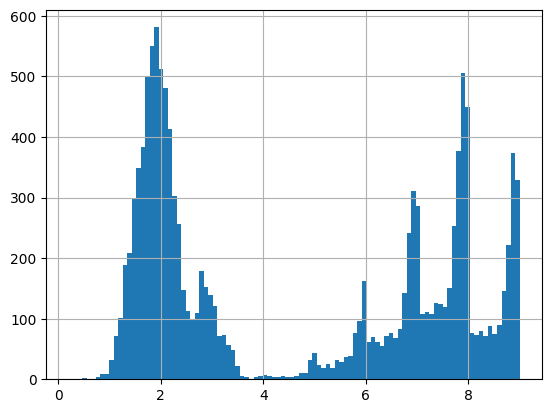

In [8]:
df_features['score'].hist(bins=100)

### An example of weighted average score-based matching

In [9]:
#https://www.wikihow.com/Calculate-Weighted-Average
from functools import reduce
weigth_factor = {'given_name':2,
                 'surname':2, 
                 'date_of_birth':1,
                 'soc_sec_id':3,
                 'address_1':1,
                 'address_2':1,
                 'suburb':1,
                 'postcode':1,
                 'state':1}

def _weighted_average_classifier(features,threshold,weigth_factor):
    
    df_score = features.copy()
    weighted_list =[]
    factor_sum = 0
    for col,wf in weigth_factor.items():
        weighted_list.append(df_score[col]*wf)
        factor_sum += wf
    weighted_sum = reduce(lambda x, y: x.add(y, fill_value=0), weighted_list)
    df_score['score'] = weighted_sum/factor_sum
    matches = df_score[df_score['score'] >=threshold]
    
    return matches,df_score

threshold = 0.4
wa_matches, wa_df_score= _weighted_average_classifier(features,threshold,weigth_factor)
print("Number of matches with weighted average  is : {} using a threshold of {}.".format(len(wa_matches),threshold))

Number of matches with weighted average  is : 6289 using a threshold of 0.4.


### Histogram of weighted score

<Axes: >

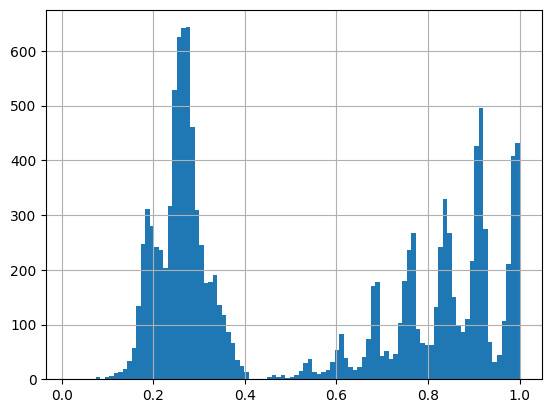

In [10]:
wa_df_score['score'].hist(bins=100)

## Evaluation

In [11]:
# gold_ standard or known truth
IMPORT_FILE_GOLD_STANDARD = './data/dataset_febrl3_true_links.csv'
df_true_links = pd.read_csv(IMPORT_FILE_GOLD_STANDARD)
df_true_links.set_index(['rec_id_1','rec_id_2'],inplace=True)
df_true_links.head()

Empty DataFrame
Columns: []
Index: [(rec-552-dup-1, rec-552-dup-3), (rec-552-dup-0, rec-552-dup-3), (rec-552-dup-0, rec-552-dup-1), (rec-552-org, rec-552-dup-3), (rec-552-org, rec-552-dup-1)]

### Create function to caculate metrics

In [12]:
def metrics(links_true,links_pred,pairs):
    if len(links_pred) > 0 :
        matrix  = rl.confusion_matrix(links_true, links_pred, len(pairs))
            
        # precision
        precision  = rl.precision(links_true, links_pred)

         #precision
        recall  = rl.recall(links_true, links_pred)

        # The F-score for this classification is
        fscore = rl.fscore(links_true,links_pred)
        
        return {'precision':precision, 'recall':recall,'fscore':fscore}
    else :
        return {'precision':0, 'recall':0,'fscore':0}

### Create Function to Print Results

In [15]:
## Create Function to Print Results
def get_results(metrics):
    print("\n{0:20}    {1:6}    {2:6}    {3:6}".format('Matching ','Precision','Recall','Fscore'))
    print('------------------------------------------------------')
    for i in metrics.keys():
        print("{0:20}    {1:<6.4}      {2:<6.4}      {3:<6.4}".format(i,metrics[i]['precision'],
                                                                      metrics[i]['recall'],
                                                                      metrics[i]['fscore']))

### Calculate quality metrics

In [16]:
results_score = {}

results_score['SimSum'] =  metrics(df_true_links,match,features)
results_score['WeightedAverage'] = metrics(df_true_links,wa_matches,features)

### Evaluation results

In [39]:
get_results(results_score)


Matching                Precision    Recall    Fscore
------------------------------------------------------
SimSum                  1.0         0.9587      0.9789
WeightedAverage         0.9983      0.9602      0.9789
